<a href="https://colab.research.google.com/github/reissonsaavedramiguel/BTCPrizeForecasting/blob/main/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

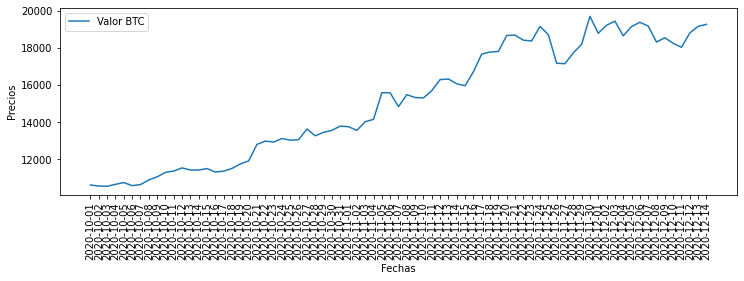

In [12]:
import requests
import matplotlib.pyplot as plt                 # version: 2.2.3

fechaInicio='2020-10-01'
fechaFin='2020-12-15'

TICKER_API_URL = 'https://api.coindesk.com/v1/bpi/historical/close.json?start='+fechaInicio+'&end='+fechaFin

def get_latest_crypto_price():
  response = requests.get(TICKER_API_URL)
  response_json = response.json()
  return response_json

response = get_latest_crypto_price()
prices = response['bpi']

dates=[]
valuePrices=[]

for i in prices:
  dates.append(i)
  valuePrices.append(prices[i])

def graficarData(dates,valuePrices):
    """ Plots to track the history of the metrics"""
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.xlabel('Fechas')
    plt.ylabel('Precios')
    plt.plot(dates, valuePrices, label='Valor BTC')

    plt.xticks(rotation=90)
#     plt.ylim([0.5, 0.7])
    plt.legend()
    plt.tight_layout()
    plt.show()

graficarData(dates,valuePrices)

In [3]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'
hist.pop('conversionType')
hist.pop('conversionSymbol')
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-03-21,9184.51,8778.69,8920.53,109985.22,9.913764e+08,8911.35
2018-03-22,9107.00,8500.88,8911.37,116522.98,1.023287e+09,8724.98
2018-03-23,8935.88,8307.58,8724.98,109649.39,9.399973e+08,8934.80
2018-03-24,9036.23,8515.53,8935.51,93296.24,8.276632e+08,8548.06
2018-03-25,8690.36,8395.85,8548.39,76775.64,6.576435e+08,8472.84
...,...,...,...,...,...,...
2020-12-11,18295.10,17598.13,18250.47,45166.17,8.093189e+08,18034.86
2020-12-12,18948.78,18033.05,18034.86,26150.36,4.842395e+08,18814.98
2020-12-13,19414.65,18733.67,18814.98,30902.88,5.920218e+08,19169.05


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(hist, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

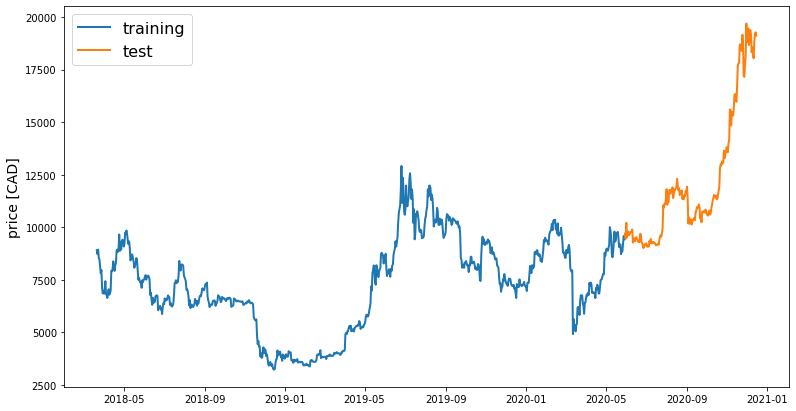

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=200, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='nadam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


from tensorflow import keras
import tensorflow as tf
from IPython.display import clear_output


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.i += 1

        # lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # if ((self.val_losses[-1] <= .05)):
        #     lr_modified = lr / 1.2
        #     tf.keras.backend.set_value(self.model.optimizer.lr, lr_modified)        

        clear_output(wait=True)

        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

        # if(logs.get('accuracy') >= 0.999):
        #   print("\nReached 99.9% accuracy so cancelling training!")
        #   self.model.stop_training = True

plot_losses = PlotLosses()

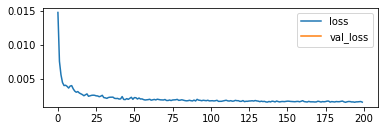

13/13 [==============================] - 1s 65ms/step - loss: 0.0015


In [9]:
np.random.seed(42)
window_len = 20
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 200
batch_size = 64
loss = 'mse'
dropout = 0.2   
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(hist, 
                                                             target_col, 
                                                             window_len=window_len, 
                                                             zero_base=zero_base, 
                                                             test_size=test_size)

model = build_lstm_model(
    X_train, 
    output_size=1, 
    neurons=lstm_neurons, 
    dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                     
                    batch_size=batch_size, 
                    verbose=1,  
                    shuffle=True,
                    callbacks = [plot_losses]) 

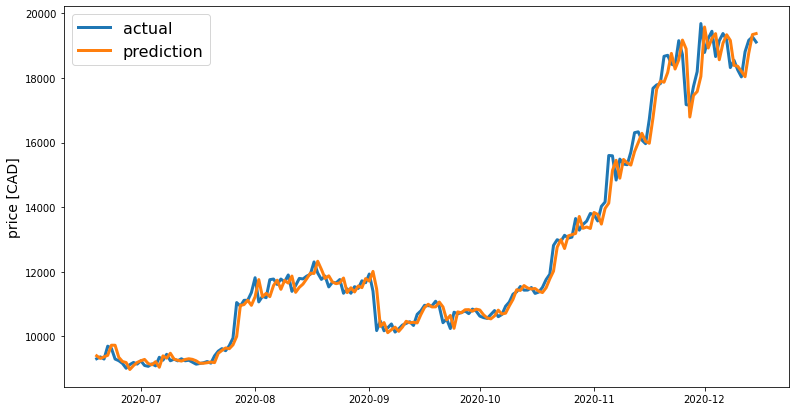

In [11]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

## Model prediction for BTC
# hyperparameters 